In [1]:
import numpy as np
# from YoungTree3 import yroot
# from YoungTree3 import yleaf
from YoungTree3.ytool import *
# from ytool import *
from numpy.lib.recfunctions import append_fields
from tqdm import tqdm
import matplotlib.pyplot as plt
from rur import uri, uhmi
import copy
from matplotlib.colors import Normalize

In [2]:
params = importlib.import_module("params")
#########################################################
#   From params.py, record to dictionary
#########################################################
p = {}
for key in params.__dict__.keys():
    if not "_" in key:
        p[key] = params.__dict__[key]
    p["flush_GB"] = params.flush_GB
p = DotDict(p)

In [3]:
mode = 'y07206'
repo, rurmode, dp = mode2repo(mode)
yrepo = f"{repo}/YoungTree"
# For message printing
galstr = "Halo"
galstrs = "Halos"
if p.galaxy:
    galstr = "Galaxy"
    galstrs = "Galaxies"

# Read output list
nout = load_nout(mode=mode, galaxy=p.galaxy)
nstep = load_nstep(mode=mode, galaxy=p.galaxy, nout=nout)

In [18]:
ptree = pklload(f"{repo}/ptree/ptree_stable.pkl")
def pbranch(iout, iid, ptree):
    temp = ptree[(ptree['timestep']==iout)&(ptree['hmid']==iid)][0]
    last = temp['last']
    return ptree[ptree['last']==last]

ytree = pklload(f"{repo}/YoungTree/ytree_stable.pickle")
def ybranch(iout, iid, ytree, all=True):
    temp = ytree[(ytree['timestep']==iout)&(ytree['id']==iid)][0]
    last = temp['last']
    if all:
        return ytree[np.abs(ytree['last'])==last]
    else:
        first = temp['from']
        return ytree[(ytree['last']==last)&(ytree['from']==first)]

In [7]:
def drawnear(iout, galid, radii=2, centers=None, proj=[0,1], **kwargs):
    global repo; global rurmode

    uri.timer.verbose=0
    snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
    gals = uhmi.HaloMaker.load(snap, galaxy=True)
    gal = gals[galid-1]

    names = ['x', 'y', 'z']
    xname = names[proj[0]]
    yname = names[proj[1]]
    # print(xname, yname)
    names.remove(xname); names.remove(yname)
    zname = names.pop()
    # iout = gal['timestep']
    if centers is None:
        cx,cy,cz = gal[xname], gal[yname], gal[zname]
        cr = gal['r']*radii
    else:
        gal = np.empty( (1,), dtype=[("id", "<i4"), ("x", "<f8"), ("y", "<f8"), ("z", "<f8"), ("r", "<f8"),])[0]
        cx,cy,cz,cr = centers
        gal[xname]=cx; gal[yname]=cy; gal[zname]=cz; gal['r']=cr/radii
        gal['id'] = 0
    # print(cx,cy,cz,cr)
    
    
    gals = gals[
            (gals[xname] >= cx-cr) & (gals[xname] <= cx+cr) &
            (gals[yname] >= cy-cr) & (gals[yname] <= cy+cr) &
            (gals[zname] >= cz-cr) & (gals[zname] <= cz+cr)
            ]

    snap.set_box_halo(gal, radius=radii, radius_name='r')
    snap.get_part(pname='star', target_fields=['id', 'x', 'y', 'z', 'm'])
    print(len(snap.part), " stars")
    xe = np.linspace(cx-cr, cx+cr, 240)
    ye = np.linspace(cy-cr, cy+cr, 240)
    hist, _, _ = np.histogram2d(snap.part[xname], snap.part[yname], bins=[xe, ye], weights=snap.part['m'])

    fig, ax = plt.subplots()
    ax.set_aspect(1)
    ax.set_facecolor("k")
    fig.set_facecolor("k")
    dpi = kwargs.pop("dpi", None)
    if dpi is None: dpi = 150
    fig.set_dpi(dpi)

    ax.imshow(np.log10(hist.T), origin='lower', extent=[xe[0], xe[-1], ye[0], ye[-1]], cmap=plt.cm.pink)
    for igal in gals:
        if igal['id'] == gal['id']:
            color='cyan'
            lw = 1.5
        else:
            color='lime'
            lw = 0.5
        cir = plt.Circle((igal[xname], igal[yname]), igal['r'], facecolor='none', edgecolor=color, lw=lw)
        ax.add_artist(cir)
        ax.text(igal[xname], igal[yname], f"{igal['id']}", color=color, ha='center', va='center')
    
    ax.text(0.05, 0.95, f"{iout}", color='white', fontsize='large', transform=ax.transAxes)    

    snap.clear()
    del snap
    plt.show()
    return cx,cy,cz,cr
    

---

25054  stars


/tmp/ipykernel_63605/3077294049.py:48: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(hist.T), origin='lower', extent=[xe[0], xe[-1], ye[0], ye[-1]], cmap=plt.cm.pink)


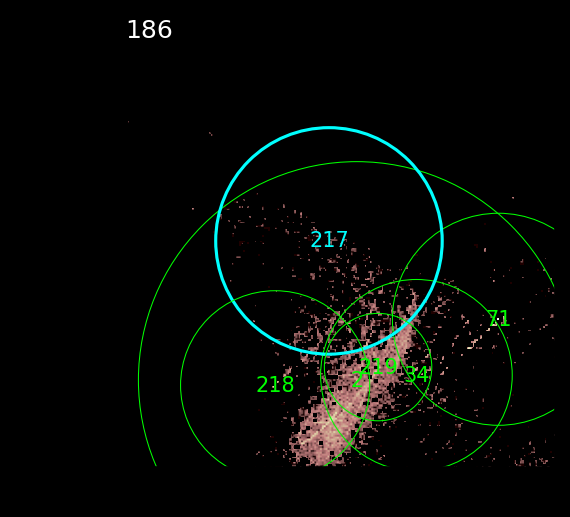

(0.24235713, 0.40827876, 0.5340167, 0.0005841512465849519)

In [8]:
drawnear(186, 217)

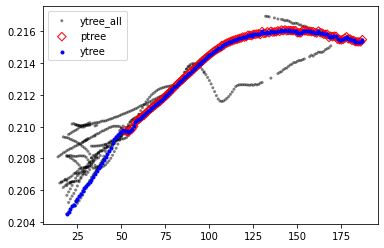

In [39]:
iout = np.random.randint(np.min(nout), np.max(nout))
leng = howmany(ytree['timestep']==iout, True)
iid = np.random.randint(0, leng-1)+1

parr = pbranch(iout, iid, ptree)
yarr = ybranch(iout, iid, ytree, all=False)
yarr_all = ybranch(iout, iid, ytree, all=True)


plt.scatter(yarr_all['timestep'], yarr_all['x'], facecolor='k', marker='.', label='ytree_all', edgecolor='none', alpha=0.5)
plt.scatter(parr['timestep'], parr['x'], edgecolor='r',facecolor='none', marker='D', label='ptree')
plt.scatter(yarr['timestep'], yarr['x'], facecolor='b', marker='.', label='ytree')

plt.legend()


In [41]:
yarr_all.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('aexp', '<f4'), ('m', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('r', '<f4'), ('rvir', '<f4'), ('mvir', '<f4'), ('prog', 'O'), ('prog_score', 'O'), ('desc', 'O'), ('desc_score', 'O'), ('last', '<i4'), ('from', '<i4'), ('fat', '<i4'), ('son', '<i4'), ('fat_score', '<f8'), ('son_score', '<f8')])

In [21]:
raise ValueError()

ValueError: 

-------------

In [ ]:
def visualize(iout, galid, gals, nbefo=5, nnext=7, radii=7, key='x'):
    last = _last(iout, galid, gals)
    lasts = [last]
    temps = samelast(last, gals)
    temps = temps[(temps['timestep'] >= iout-nbefo)&(temps['timestep'] <= iout+nnext)]
    for temp in temps:
        nears = cut_sphere(gals, temp['x'], temp['y'], temp['z'], temp['r']*radii)
        for near in nears:
            lasts.append(_last(near['timestep'], near['id'], gals))
    lasts = np.unique(lasts)
    for last in lasts:
        temps = samelast(last, gals)
        temps = temps[(temps['timestep'] >= iout-nbefo)&(temps['timestep'] <= iout+nnext)]
        if len(temps)>0:
            plt.plot(temps[key], temps['timestep'])
            plt.text(temps[0][key], temps[0]['timestep']+np.random.rand(), f"{last}")
    plt.gcf().set_dpi(300)
    plt.show()

visualize(141, 314, gals, key='z')

NameError: name 'gals' is not defined

In [ ]:
raise ValueError("stop")

ValueError: stop